<a href="https://colab.research.google.com/github/joyinning/causal_inference/blob/main/Causal_Week_6_2_(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 7 -
Beyond Confounders introduces two methods of analyzing data: the Average Treatment Effect method and the Regression Method. It focuses on identifying variables that should be added to or avoided in models, rather than introducing new theories. This chapter explains specific methodologies for estimating causal effects in data analysis in detail. By reading through the content sequentially and solving problems, you can develop the skills to effectively apply these methodologies in actual data analysis.

For the regression method, use sklearn library instead of statsmodels library.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

**Q1. Figure out the impact of sending an email asking people to negotiate their debt using two methods, the Average Treatment Effect method & Regression Method and interpret the result from both methods using “collections_email.csv” dataset.**

In [2]:
data = pd.read_csv("/content/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


The ATE is -0.62, which means sending an email make late customers pay less than average. But the p-value is higher than the standard, 0.05, so we would conclude it is not statistically significant. (It doesn't mean anything.)

**Q2. Investigate a potential causal relationship between the 'email' variable and the 'payments' variable using a two-stage residual inclusion approach with Confounding Variables(credit_limit & risk_score) and interpret the result using “collections_email.csv” dataset.**<br>
two-stage residual inclusion approach<br>
- Step1: Regress the treatment, email, and the outcome, payments, on the additional controls, credit limit and risk score.
- Step2: Regress the residual of the treatment on the residuals of payments, both obtained in step1


In [4]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

In [5]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466208
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.239e-13,1.063,-1.17e-13,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605


We've decreased it by almost half once we control for risk and credit limits. Risk and credit line does not predict email.

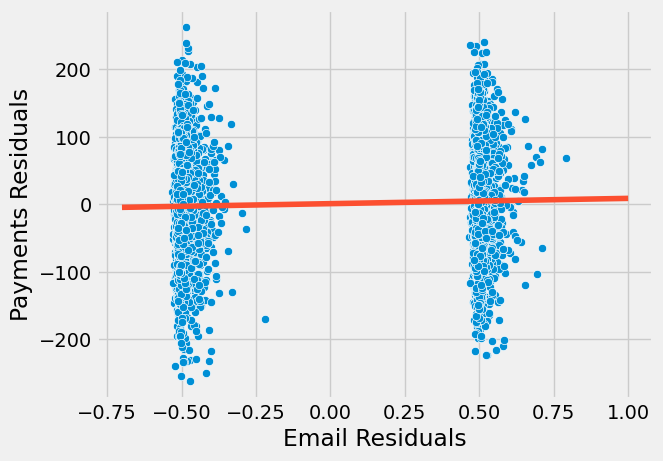

In [6]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

**Q3. Anytime we have a control that is a good predictor of the outcome, even if it is not a confounder, adding it to our model is a good idea. Why?**



It helps lowering the variance of the treatment effect estimates.

**Q4. Analyze the data involved running a simple regression model with the days hospitalized as the outcome and the treatment (drug or placebo) as the predictor using the "hospital_treatment.csv" dataset**

In [7]:
hospital = pd.read_csv("/content/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [8]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


Treatment (presumably the drug) increases the number of days hospitalized by about 14.15 days compared to the placebo, indicating strong evidence against the null hypothesis)

**Q5. From the hospital_treatment case, why does the initial analysis(Q4) suggest that the treatment is increasing the number of days in the hospital?**


- Positive Coefficient: The positive value directly implies that the treatment is linked to a longer duration of hospital stay compared to the placebo.
- Statistical Significance: This very low p-value suggests that the probability of observing such a substantial effect of treatment on days hospitalized due to random chance alone is extremely unlikely.
- Large t-Statistics: it measures how many standard deviations the estimated coefficient is from zero. (The treatment has no effect on days hospitalized because of the large t-Statistic)
- Confidence Interval: The effect of the treatment is significantly different from no effect, because the interval does not include zero.

**Q6.To address the issue from Q5, two methods were proposed in the reading. Analyze the data using both methods (the Average Treatment Effect method & Regression Method) and explain if you are able to find statistically significant results or not. If not, why?**
Bad Controls - Selection Bias


In [9]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [10]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


**Q7. Why does the second model, which includes additional variables 'opened' and 'agreement' alongside email, credit limit, and risk score, experience selection bias?**


**Q8. Imagine we are studying the impact of a workplace health program on employees' sick days with variables below. Create a causal diagram and identify which variables we should include in the model and which ones we should exclude.**
- 'health_program': Whether or not an employee is enrolled in a health program offered by their employer.
- 'baseline_health': The general health status of employees before entering the program
- 'job_stress_level': The level of stress associated with an employee's job role
- 'program_engagement': Whether an employee actively participates in the health program
- 'lifestyle_change': Whether the employee makes concrete changes in their lifestyle as a part of program engagement, like improving their diet or exercising regularly.